In [1]:
from pathlib import Path

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.analysis import lyapunov_gr
from dynamical_systems.continuous import Lorenz63, solve_ode
from dynamics_discovery.data.utils import generate_ode_dataset
from matplotlib_utils.plots import plot_line_and_band


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

## Generate dataset

In [5]:
lorenz = Lorenz63()
solve_lorenz_batch = eqx.filter_jit(
    eqx.filter_vmap(
        lambda ts, u0_: solve_ode(
            lorenz, ts, u0_, rtol=1e-8, atol=1e-8, max_steps=None
        ),
        in_axes=(None, 0),
    )
)
u0 = jax.random.normal(jax.random.PRNGKey(1), shape=(20000, lorenz.dim))

t = jnp.arange(0, 100, 0.01)
u = solve_lorenz_batch(t, u0)

2025-08-20 16:51:15.091969: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 11.41GiB (12251553225 bytes) by rematerialization; only reduced to 13.41GiB (14400480128 bytes), down from 13.41GiB (14400480136 bytes) originally


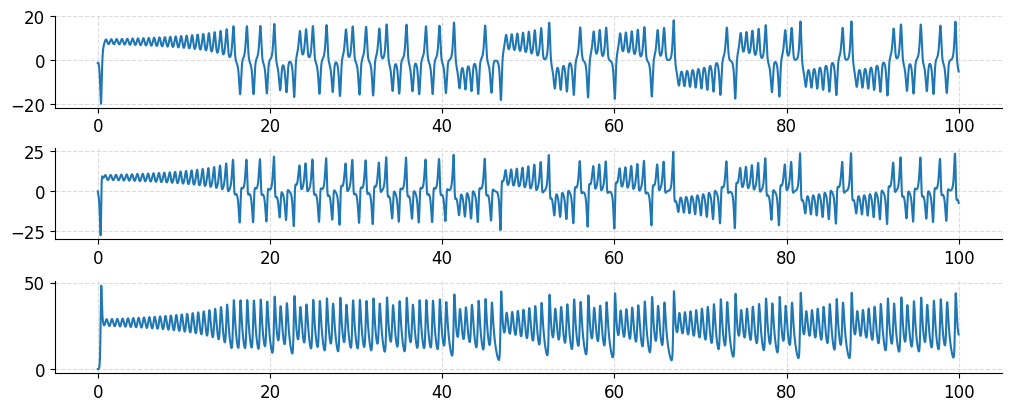

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(10, 4))
for i, ax in enumerate(axes):
    ax.plot(t, u[0, :, i])

We will use t_burnin = 40

In [7]:
t_burnin = 40

u0_init = jax.random.normal(jax.random.PRNGKey(1), shape=(20000, lorenz.dim))
u0 = solve_lorenz_batch(jnp.asarray([0, t_burnin]), u0_init)[:, -1]

u0.shape

(20000, 3)

We find the lyapunov exponents of the system

In [8]:
t_lya = jnp.arange(0.0, 100.0, 0.05)
lyas = eqx.filter_vmap(
    lambda u0_: lyapunov_gr(lorenz, u0_, t_lya, rtol=1e-8, atol=1e-8)[0]
)(u0)[1:]

In [9]:
lyas_mean, lyas_std = jnp.mean(lyas, axis=0), jnp.std(lyas, axis=0)

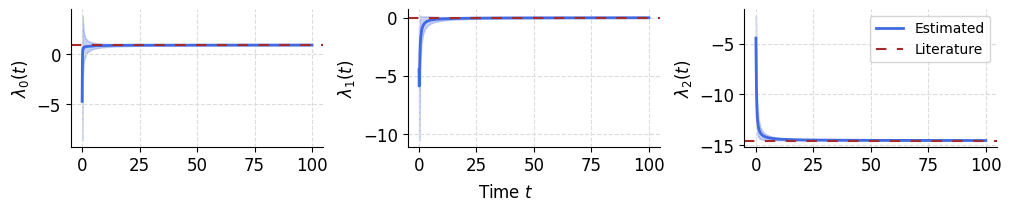

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2), sharex=True)

plot_kwargs = {"linewidth": 2.0, "alpha": 1.0}
# ax.set_yscale("symlog", base=10)

lya_known = (0.9057, 1.4e-5, -14.5724)

for i, ax in enumerate(axes.flat):
    plot_line_and_band(
        ax, t_lya, lyas_mean[:, i], lyas_std[:, i], label="Estimated", **plot_kwargs
    )
    ax.axhline(
        y=lya_known[i],
        color="brown",
        linewidth=1.5,
        linestyle="--",
        dashes=(5, 5),
        label="Literature",
    )
    ax.set_ylabel(rf"$\lambda_{i}(t)$")

axes[-1].legend(loc="upper right", fontsize="small")
fig.supxlabel("Time $t$", fontsize="medium")
fig.align_ylabels()

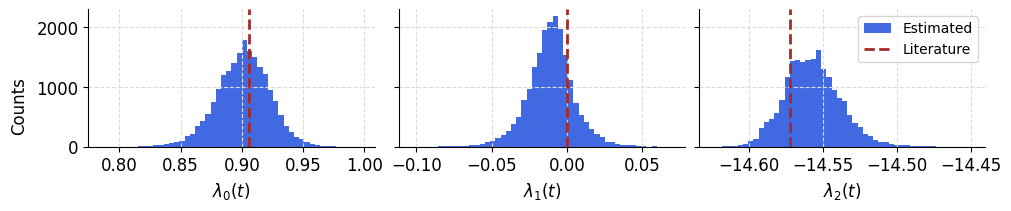

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2), sharey=True)

plot_kwargs = {"linewidth": 2.0, "alpha": 1.0}
# ax.set_yscale("symlog", base=10)

lya_known = (0.9057, 1.4e-5, -14.5724)

for i, ax in enumerate(axes.flat):
    ax.hist(lyas[:, -1, i], bins=50, color="royalblue", label="Estimated")
    ax.axvline(
        x=lya_known[i],
        color="brown",
        linewidth=2.0,
        linestyle="--",
        label="Literature",
    )
    ax.set_xlabel(rf"$\lambda_{i}(t)$")

axes[-1].legend(loc="upper right", fontsize="small")
fig.supylabel("Counts", fontsize="medium")
fig.align_ylabels()

In [13]:
lya_max = jnp.max(lyas_mean[-1])
lya_max

Array(0.90117487, dtype=float64)

In [14]:
# Train data: seed=0, num_data = 5000
# Test data: seed=1, num_data=20000
dataset = generate_ode_dataset(
    lorenz,
    40.0,
    (0.0, 100.0 / lya_max),
    0.01 / lya_max,
    20000,
    rtol=1e-8,
    atol=1e-8,
    max_steps=None,
    seed=1,
)

2025-08-20 16:52:15.380459: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 11.41GiB (12251553225 bytes) by rematerialization; only reduced to 13.41GiB (14400480128 bytes), down from 13.41GiB (14400480136 bytes) originally


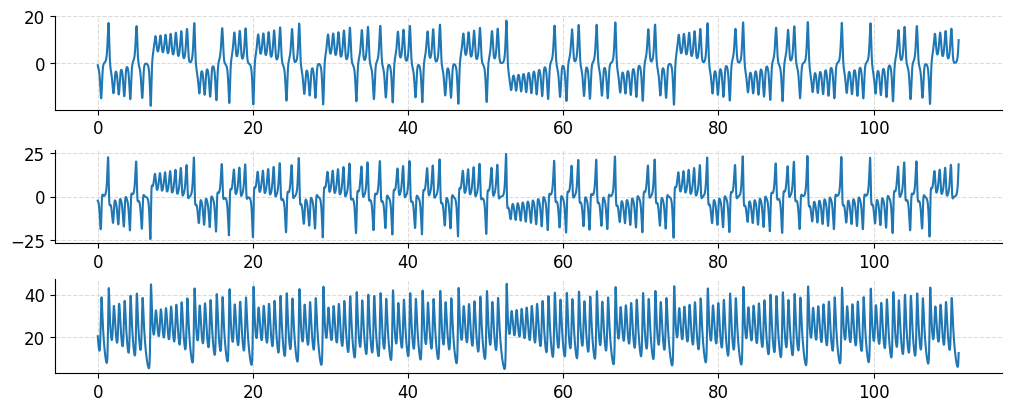

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(10, 4))

t, u = dataset[0]
for i, ax in enumerate(axes):
    ax.plot(t, u[:, i])

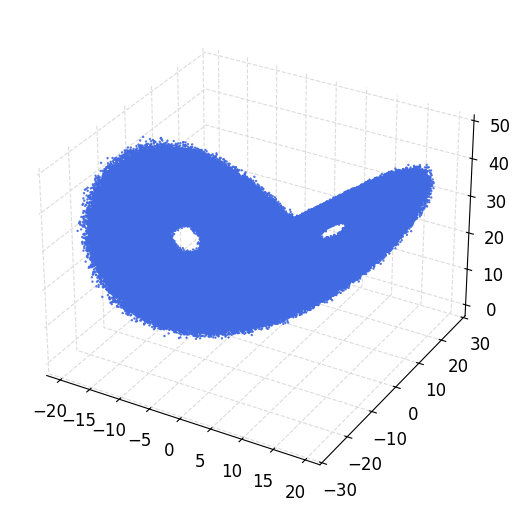

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={"projection": "3d"})
ax.scatter(*dataset.u.reshape(-1, 3)[::100].T, s=0.5, color="royalblue", alpha=0.9)

## Save the results

In [ ]:
datadir = Path("../../data")
dataset.to_hdf5(datadir / "lorenz63_large_test.hdf5")

# ## Also save the Lyapunov exponent related results since this is quite expensive to do
jnp.savez(
    datadir / "lorenz63_lyapunov_large_test.npz",
    t=t_lya,
    lyas=lyas,
    lyas_literature=jnp.asarray((0.9057, 1.4e-5, -14.5724)),
)

: 